## Development of the simulation model

In [1]:
from distributions import DistRand
import matplotlib.pyplot as plt
import pandas as pd
from tests import DistributionsTests
import warnings

warnings.filterwarnings('ignore')

[1.5551248711218286, -6.285547329302091, -6.801193178616214, 6.938879139515761, 7.950991691596322, -8.066493690388496, 2.368677098441042, 14.775522243284069, 4.28845791729373, 8.244254426197891]


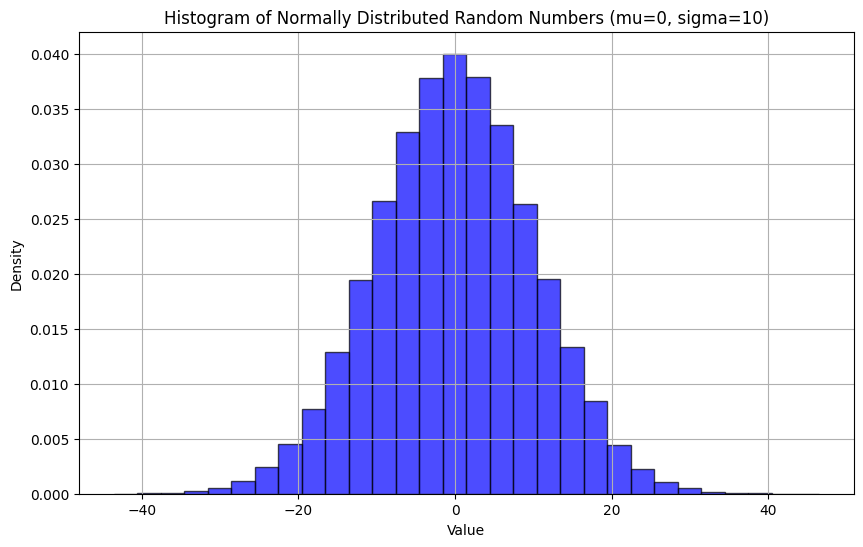

[8.108821150381118, 7.886017858982086, 6.237401885446161, 3.7340519996359944, 5.265373832080513, 8.738523544743657, 3.26399416429922, 2.2470098873600364, 6.493437692988664, 1.736601684242487]


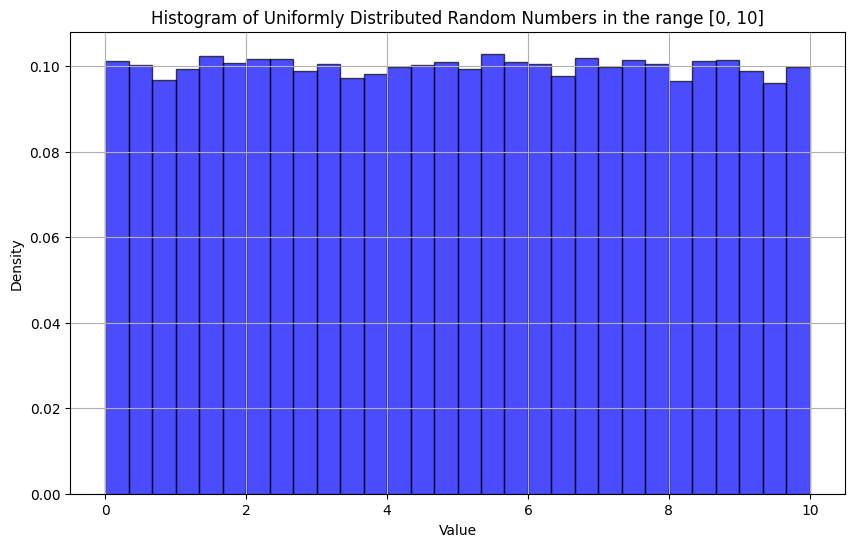

[0.4192651859367833, 0.47498758579447536, 0.9440427236566273, 1.9701822439686736, 1.2828658933691117, 0.269687696808759, 2.2392668875846136, 2.9859693991025944, 0.8635860235228279, 3.5013098889990912]


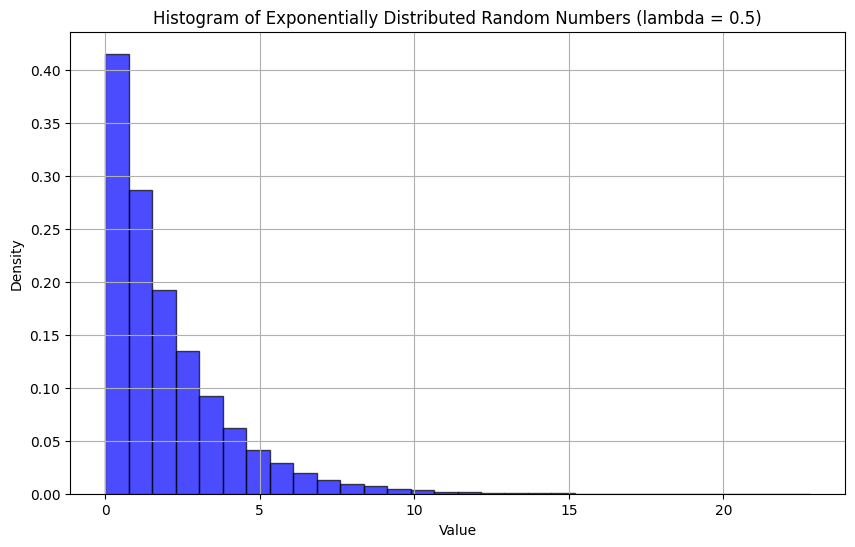

In [2]:
randomizer = DistRand()

mu, sigma, n = 0, 10, 100000
normal_data = randomizer.normal_random(mu, sigma, n)
print(normal_data[:10])
randomizer.plot_data(normal_data, f'Histogram of Normally Distributed Random Numbers (mu={mu}, sigma={sigma})')

a, b = 0, 10
uniform_data = randomizer.uniform_distribution(a, b, n)
print(uniform_data[:10])
randomizer.plot_data(uniform_data, f'Histogram of Uniformly Distributed Random Numbers in the range [{a}, {b}]')

la = 0.5
exponential_data = randomizer.exponential_distribution(la, n)
print(exponential_data[:10])
randomizer.plot_data(exponential_data, f'Histogram of Exponentially Distributed Random Numbers (lambda = {la})')




## Research on the time complexity of the algorithms

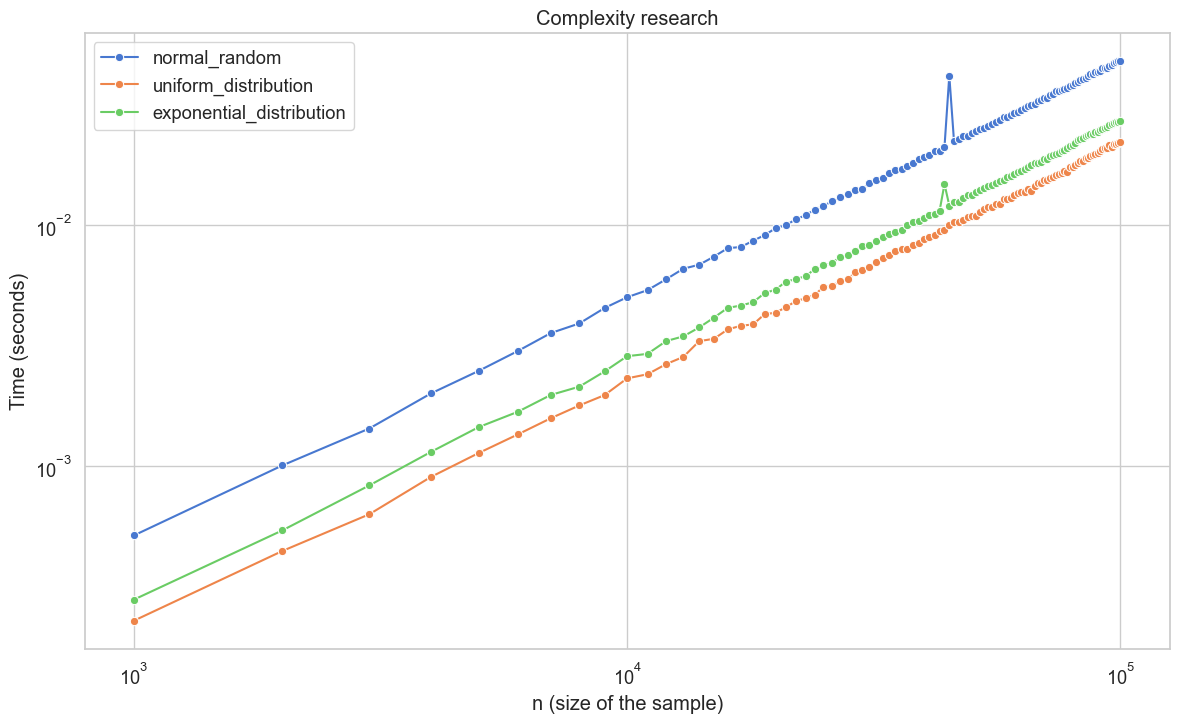

In [3]:
import time
import seaborn as sns
import matplotlib.pyplot as plt


dist = DistRand(seed=42)

def measure_time(func, *args):
    start_time = time.time()
    func(*args)
    end_time = time.time()
    return end_time - start_time


n_values = list(range(1000, 100001, 1000))


normal_times = []
uniform_times = []
exponential_times = []

for n in n_values:
    normal_times.append(measure_time(dist.normal_random, 0, 1, n))         # mu=0, sigma=1, n=n
    uniform_times.append(measure_time(dist.uniform_distribution, 0, 1, n)) # a=0, b=1, n=n
    exponential_times.append(measure_time(dist.exponential_distribution, 1, n)) # la=1, n=n


sns.set(style="whitegrid", palette="muted", font_scale=1.2)


plt.figure(figsize=(14, 8))

sns.lineplot(x=n_values, y=normal_times, label='normal_random', marker='o')
sns.lineplot(x=n_values, y=uniform_times, label='uniform_distribution', marker='o')
sns.lineplot(x=n_values, y=exponential_times, label='exponential_distribution', marker='o')

plt.title('Complexity research')
plt.xlabel('n (size of the sample)')
plt.ylabel('Time (seconds)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


## Research on the correspondence of the obtained results to the distribution parameters

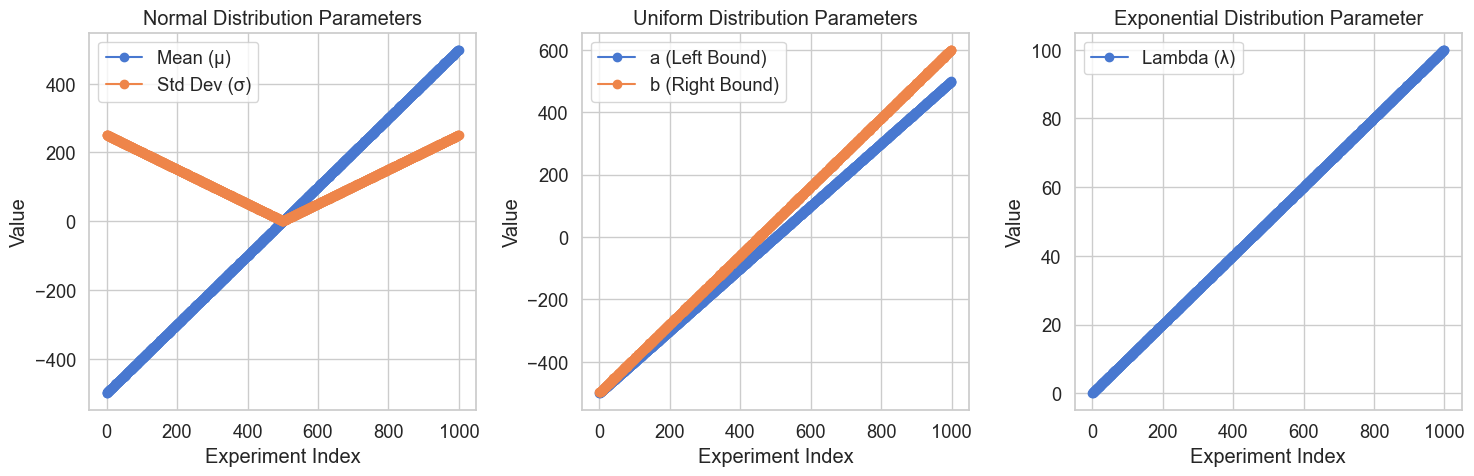

In [4]:
tests = DistributionsTests()
generator = DistRand()


experiments_count = 1000
sample_size = 10000

normal_params = [(i - experiments_count // 2, abs((i - experiments_count // 2) / 2) + 1) for i in range(experiments_count)]
uniform_params = [(i - experiments_count // 2, (i - experiments_count // 2) + 1 + abs((i - experiments_count // 2) % 3) + i // 10) for i in range(experiments_count)]
exponential_params = [(0.1 + i * 0.1,) for i in range(experiments_count)]


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Normal Distribution Parameters', 'Uniform Distribution Parameters', 'Exponential Distribution Parameter']
data = [
    (normal_params, ['Mean (μ)', 'Std Dev (σ)']),
    (uniform_params, ['a (Left Bound)', 'b (Right Bound)']),
    (exponential_params, ['Lambda (λ)'])
]

for ax, (params, labels), title in zip(axes, data, titles):
    for i, label in enumerate(labels):
        ax.plot([p[i] for p in params], marker='o', label=label)
    ax.set_title(title)
    ax.set_xlabel('Experiment Index')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

# random.shuffle(normal_params)
# random.shuffle(uniform_params)
# random.shuffle(exponential_params)

distributions_params = {
    'normal': {
        'params': normal_params,
        'generator': generator.normal_random
    },
    'uniform': {
        'params': uniform_params,
        'generator': generator.uniform_distribution
    },
    'exponential': {
        'params': exponential_params,
        'generator': generator.exponential_distribution
    }
}


def run_experiments():
    all_results = []
    
    for dist_type, dist_info in distributions_params.items():
        params_list = dist_info['params']
        generator_func = dist_info['generator']
        
        for exp_num in range(1, experiments_count + 1):
            params = params_list[exp_num - 1]
            
            data = generator_func(*params, sample_size)
            

            mean_deviation, variance_deviation, mv_stats = tests.calculate_mean_var(data, dist_type, params)
            chi_desigion, chi_stats = tests.chi_squared_test(data, dist_type, params)
            X_desigion, X_stats = tests.lambda_criterion(data, dist_type, params)
            

            
            result_row = {
                'Experiment': exp_num,
                'Distribution': dist_type,
                'Parameters': params,

                'Mean Test': f"{mv_stats[0]:.4f}",
                'Mean Theoretical': f"{mv_stats[2]:.4f}",
                'Variance Test': f"{mv_stats[1]:.4f}",
                'Variance Theoretical': f"{mv_stats[3]:.4f}",
                'Mean Deviation': f"{mean_deviation:.4f}",
                'Variance Deviation': f"{variance_deviation:.4f}",
                
                'Chi2 Test': chi_desigion,
                'Chi2 Stat': f"{chi_stats[1]:.4f}",
                'Chi2 Critical': f"{chi_stats[2]:.4f}",
                
                'Lambda Test': X_desigion,
                'Lambda Stat': f"{X_stats[1]:.4f}",
                'Lambda Critical': f"{X_stats[2]:.4f}"
            }
            
            all_results.append(result_row)
            

    df = pd.DataFrame(all_results)
    return df


df_results = run_experiments()
df_results.to_csv('distribution_tests_results.csv', index=False)


In [5]:

chi2_test_results = df_results['Chi2 Test'] == True
lambda_test_results = df_results['Lambda Test'] == True


chi2_true_count = chi2_test_results.sum()
chi2_false_count = len(chi2_test_results) - chi2_true_count

lambda_true_count = lambda_test_results.sum()
lambda_false_count = len(lambda_test_results) - lambda_true_count


print(f"\nChi2 Test: {chi2_true_count} True, {chi2_false_count} False")
print(f"\nLambda Test: {lambda_true_count} True, {lambda_false_count} False")


chi2_failed_tests = df_results[~chi2_test_results]
lambda_failed_tests = df_results[~lambda_test_results]

print("\nFailed Chi2 Tests:")
print(chi2_failed_tests)

print("\nFailed Lambda Tests:")
print(lambda_failed_tests)



Chi2 Test: 3000 True, 0 False

Lambda Test: 3000 True, 0 False

Failed Chi2 Tests:
Empty DataFrame
Columns: [Experiment, Distribution, Parameters, Mean Test, Mean Theoretical, Variance Test, Variance Theoretical, Mean Deviation, Variance Deviation, Chi2 Test, Chi2 Stat, Chi2 Critical, Lambda Test, Lambda Stat, Lambda Critical]
Index: []

Failed Lambda Tests:
Empty DataFrame
Columns: [Experiment, Distribution, Parameters, Mean Test, Mean Theoretical, Variance Test, Variance Theoretical, Mean Deviation, Variance Deviation, Chi2 Test, Chi2 Stat, Chi2 Critical, Lambda Test, Lambda Stat, Lambda Critical]
Index: []


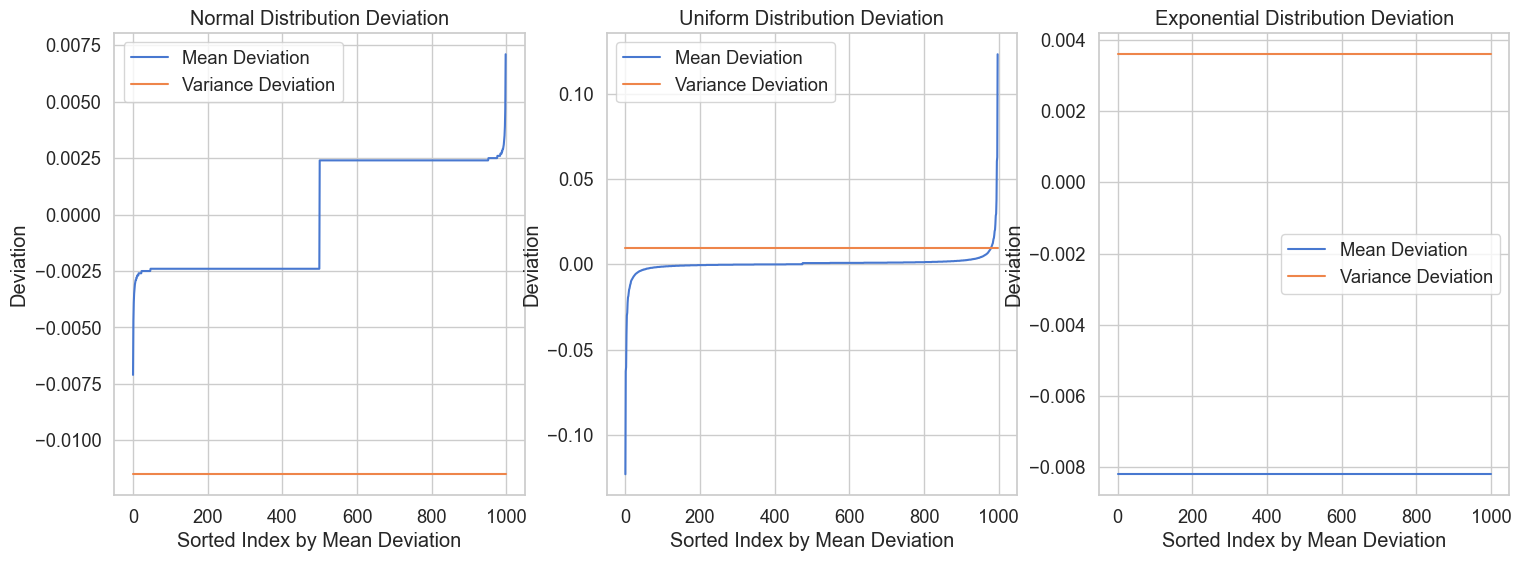

In [6]:

def get_results_by_distribution(df, distribution):
    results = df[df['Distribution'] == distribution]
    results['Mean Deviation'] = pd.to_numeric(results['Mean Deviation'], errors='coerce')
    results['Variance Deviation'] = pd.to_numeric(results['Variance Deviation'], errors='coerce')
    return results.sort_values(by='Mean Deviation')


def plot_deviations(df, distributions):
    plt.figure(figsize=(18, 6))

    for i, dist in enumerate(distributions, 1):
        sorted_results = get_results_by_distribution(df, dist)
        plt.subplot(1, 3, i)
        plt.plot(sorted_results['Mean Deviation'].values, label='Mean Deviation')
        plt.plot(sorted_results['Variance Deviation'].values, label='Variance Deviation')
        plt.title(f'{dist.capitalize()} Distribution Deviation')
        plt.xlabel('Sorted Index by Mean Deviation')
        plt.ylabel('Deviation')
        plt.legend()

    plt.show()


distributions = ['normal', 'uniform', 'exponential']
plot_deviations(df_results, distributions)


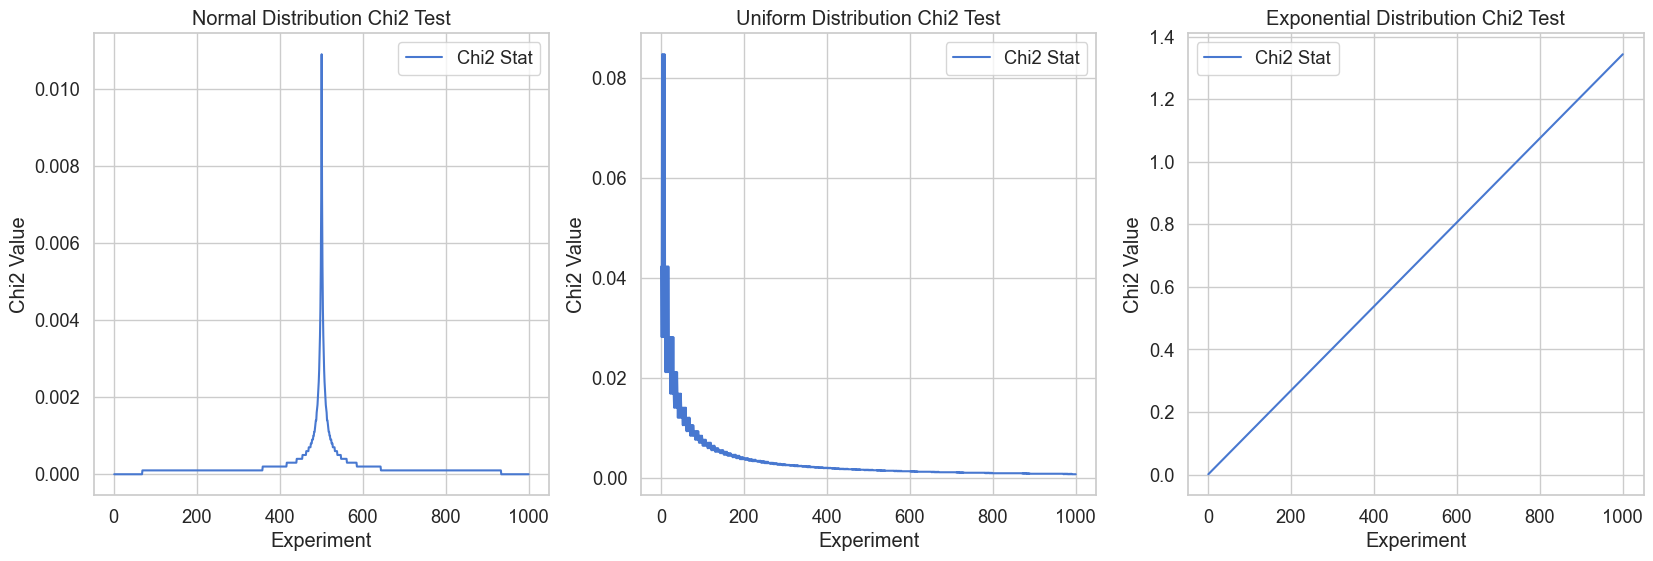

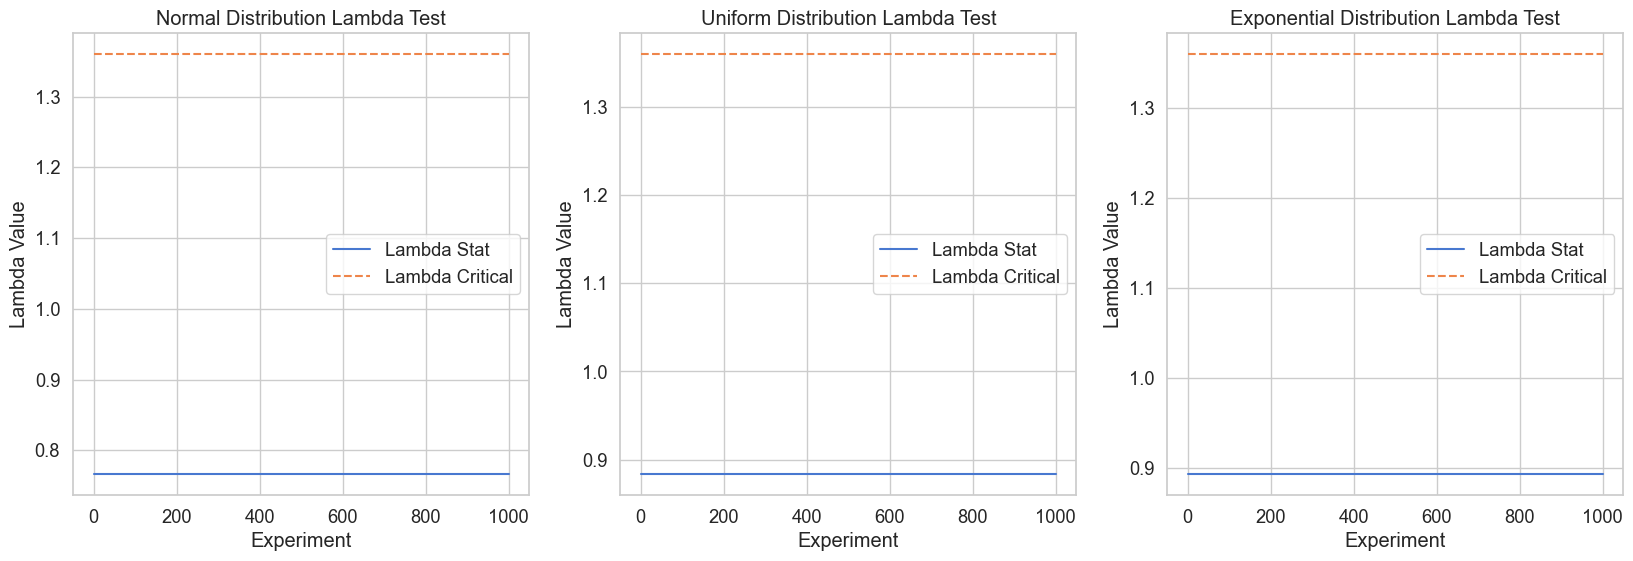

In [7]:
normal_results = df_results[df_results['Distribution'] == 'normal']
uniform_results = df_results[df_results['Distribution'] == 'uniform']
exponential_results = df_results[df_results['Distribution'] == 'exponential']


def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


def plot_test_results(results, stat_label, critical_label, title_prefix, ylabel, show_crit=True):
    distributions = ['Normal', 'Uniform', 'Exponential']
    plt.figure(figsize=(20, 6))

    for i, dist in enumerate(distributions, 1):
        plt.subplot(1, 3, i)
        x_values = results[dist]['Experiment']
        plt.plot(x_values, results[dist][stat_label], label=stat_label)
        if show_crit:
            plt.plot(x_values, results[dist][critical_label], label=critical_label, linestyle='--')
        plt.title(f'{dist} Distribution {title_prefix} Test')
        plt.xlabel('Experiment')
        plt.ylabel(ylabel)
        plt.legend()

    plt.show()


results = {
    'Normal': normal_results,
    'Uniform': uniform_results,
    'Exponential': exponential_results
}


for df in results.values():
    convert_to_numeric(df, ['Chi2 Stat', 'Chi2 Critical', 'Lambda Stat', 'Lambda Critical'])


plot_test_results(results, 'Chi2 Stat', 'Chi2 Critical', 'Chi2', 'Chi2 Value', show_crit=False)
plot_test_results(results, 'Lambda Stat', 'Lambda Critical', 'Lambda', 'Lambda Value')

